In [132]:
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

import geopandas as gpd

import rasterio
from rasterio.mask import mask
from rasterio.sample import sample_gen
from rasterio.features import shapes
import numpy as np
from shapely.geometry import Polygon, shape


from itertools import compress
from dbfread import DBF

In [2]:
corinePath = os.path.join("Z:\\", "Masterarbeit_Marius", "CORINE_data_Germany", "clc5")
corinePath

'Z:\\Masterarbeit_Marius\\CORINE_data_Germany\\clc5'

In [3]:
corineFiles = []
for file in os.listdir(corinePath):
    if file.endswith(".shp"):
        corineFiles.append(file)
        print("Found ", os.path.join(corinePath, file))

Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class4xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class2xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class5xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class1xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class3xx.shp


In [5]:
corineFiles

['clc5_class4xx.shp',
 'clc5_class2xx.shp',
 'clc5_class5xx.shp',
 'clc5_class1xx.shp',
 'clc5_class3xx.shp']

In [6]:
polygonFrame = gpd.read_file(os.path.join(corinePath, corineFiles[1]))

<Axes: >

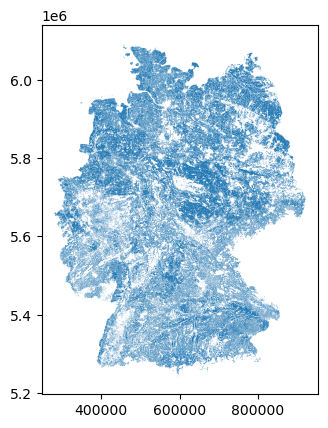

In [7]:
polygonFrame.plot()

In [3]:
raster_dir = "F:\\Persönliches\\Git\\BioOTon\\u2018_clc2018_v2020_20u1_raster100m\\DATA"

In [4]:
raster = "clcclip.tif"
dbf_file = "U2018_CLC2018_V2020_20u1.tif.vat.dbf"
raster_file = os.path.join(raster_dir, raster)
dbf_file = os.path.join(raster_dir, dbf_file)

In [5]:
dbf_data = DBF(dbf_file)
vat_df = pd.DataFrame(iter(dbf_data))
print("VAT DataFrame:\n", vat_df.head())

VAT DataFrame:
    Value       Count                                      LABEL3       Red  \
0      1    800699.0                     Continuous urban fabric  0.901961   
1      2  17085234.0                  Discontinuous urban fabric  1.000000   
2      3   3210212.0              Industrial or commercial units  0.800000   
3      4    414626.0  Road and rail networks and associated land  0.800000   
4      5    122685.0                                  Port areas  0.901961   

      Green      Blue CODE_18  
0  0.000000  0.301961     111  
1  0.000000  0.000000     112  
2  0.301961  0.949020     121  
3  0.000000  0.000000     122  
4  0.800000  0.800000     123  


In [8]:
soundscape_file = os.path.join("Z:\\Audio_data\\Dawn_chorus_raw_data", "dawn-chorus-soundscape.parquet")
sound_df = pd.read_parquet(soundscape_file)

In [ ]:
sound_df = sound_df[["id", "lat", "lng"]]

In [18]:
sound_gdf = gpd.GeoDataFrame(
    sound_df, geometry=gpd.points_from_xy(sound_df.lng, sound_df.lat), crs="EPSG:4326"
)

In [19]:
sound_gdf.to_crs("EPSG:3035", inplace=True)

In [20]:
sound_gdf.drop(["lat", "lng"], axis=1,inplace=True)

In [3]:
def getSoundLocations(dir):
    dir_files = os.listdir(dir)
    soundscape_file = os.path.join(dir, list(compress(dir_files, [file.endswith(".parquet") for file in dir_files]))[0])
    sound_df = pd.read_parquet(soundscape_file)

    sound_df = sound_df[["id", "lat", "lng"]]

    sound_gdf = gpd.GeoDataFrame(
        sound_df, geometry=gpd.points_from_xy(sound_df.lng, sound_df.lat), crs="EPSG:4326"
    )

    sound_gdf.to_crs("EPSG:3035", inplace=True)

    sound_gdf.drop(["lat", "lng"], axis=1,inplace=True)

    return sound_gdf

def getCorine(dir):
    dir_files = os.listdir(dir)
    raster_file = os.path.join(dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    # Load Raster
    with rasterio.open(raster_file) as src:
        image = src.read(1)
        
        # Get the coordinate reference system (CRS) and transform
        crs = src.crs
        transform = src.transform
        nodata = src.nodata
        
        # Create geometries for raster
        all_shapes = shapes(image, transform=transform)
        
        # Create dictionary with geometries and corresponding values
        geoms = [
            {'value': value, 'geometry': shape(geom)}
            for geom, value in all_shapes 

            # Filter out no data
            # Implementation leads to unwanted gaps
            # if value != src.nodata
        ]

        raster_gdf = gpd.GeoDataFrame(geoms, crs=crs)

    joined_df = raster_gdf.join(dbf_df, on = "value")

    return joined_df

def getRecordingNeighbourhood(sound_point, corine_df, distance=200):

    buffer = gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(distance)[0]

    return [sound_point, corine_df[corine_df.intersects(buffer)]]


In [3]:
dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
points = getSoundLocations(dir)

In [ ]:
sound_point = points.iloc[100]
sound_point

id                                              9835572
geometry    POINT (4053981.945062326 3073699.565136006)
Name: 100, dtype: object

<Axes: >

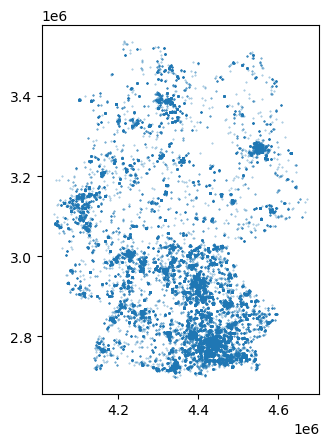

In [249]:
points.plot(markersize = 0.15, alpha= 0.55)

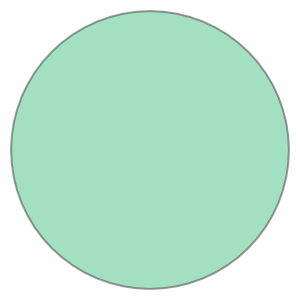

In [14]:
buffer = gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(200)
buffer[0]

In [ ]:
### Get Single point for now
### Implement numpy for faster processing?
# Later: Change algorithm so that image gets only loaded once
# Return count for each class and weigh
# Weigh closer cells more (Might need to change approach a bit in order to take raster cells instead of distance)
# Join original Dataframe, with count

In [4]:
def getCorineLocationsSingle(dir, buffer, distance=200):
    dir_files = os.listdir(dir)

    raster_file = os.path.join(dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    print("Loading raster.")
    with rasterio.open(raster_file) as tif:
        print("Loaded raster successfully. ")
        raster_crs = tif.crs

        # Reproject buffer
        if buffer.crs != raster_crs:
            print("Reprojecting buffer due to differing SRS.")
            buffer = buffer.to_crs(raster_crs)

        # Mask raster to buffer
        image_data, transformed_data = mask(
            dataset=tif,
            shapes=buffer.geometry.tolist(),
            crop=True,
            all_touched=True 
        )

        print("Clipped raster.")

        print("Generating individual pixels.")

        # Get shape
        rows, cols = image_data.shape[1:]

        # Flatten image to a single band
        pixel_values = image_data[0].flatten()

        # Create arrays of all row and column indices
        col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))
        flattened_col_indices = col_indices.flatten()
        flattened_row_indices = row_indices.flatten()

        # # Get raster resolution to compute pixel size
        x_res = abs(transformed_data.a)
        y_res = abs(transformed_data.e)

        # Calculate NW corner of the pixels
        x_ul, y_ul = transformed_data * (flattened_col_indices, flattened_row_indices)

        # North-East (NE) corner
        x_ne = x_ul + x_res
        y_ne = y_ul

        # South-East (SE) corner
        x_se = x_ul + x_res
        y_se = y_ul - y_res # Note: Assuming a north-up, y-decreasing transform

        # South-West (SW) corner
        x_sw = x_ul
        y_sw = y_ul - y_res

        # Define pixel corners in counter-clockwise order:

        geometries = [
            Polygon([
                (x_ul[i], y_ul[i]),  # NW
                (x_ne[i], y_ne[i]),  # NE
                (x_se[i], y_se[i]),  # SE
                (x_sw[i], y_sw[i]),  # SW
                (x_ul[i], y_ul[i])   # NW (Close the ring)
            ])
            for i in range(len(x_ul))
        ]

        # Create geodataframe
        gdf = gpd.GeoDataFrame(
            pd.DataFrame({
                'value': pixel_values,
            }),
            geometry=geometries,
            crs=raster_crs
        )

        # Join geodataframe with CLC
        print("Joining with CLC")
        jdf = gdf.join(dbf_df, on = "value")

        # Get only intersecting pixels
        intersection_result = jdf.intersects(buffer.unary_union)
        
    return jdf[intersection_result]
    

In [7]:
jdf = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffer)

Loading raster.
Loaded raster successfully. 
Clipped raster.
Generating individual pixels.
Joining with CLC


In [16]:
intersection_result = jdf.intersects(buffer.unary_union)
jdf[intersection_result]

,value,geometry,Value,Count,LABEL3,Red,Green,Blue,CODE_18
1,2,"POLYGON ((4053800.000 3073900.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
2,18,"POLYGON ((4053900.000 3073900.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
3,18,"POLYGON ((4054000.000 3073900.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
4,18,"POLYGON ((4054100.000 3073900.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
5,2,"POLYGON ((4053700.000 3073800.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
6,2,"POLYGON ((4053800.000 3073800.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
7,18,"POLYGON ((4053900.000 3073800.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
8,18,"POLYGON ((4054000.000 3073800.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
9,18,"POLYGON ((4054100.000 3073800.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
10,2,"POLYGON ((4053700.000 3073700.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121


In [10]:
def plotRecord(geodataframe, buffer):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    geodataframe.plot(ax=ax, column="CODE_18", legend=True)

    buffer.plot(ax=ax, color='green', alpha = 0.7)
    gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").plot(ax=ax, color='black', edgecolor='white')
    plt.grid()
    for idx, row in geodataframe.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        
        ax.annotate(
            text=str(idx),
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    return fig

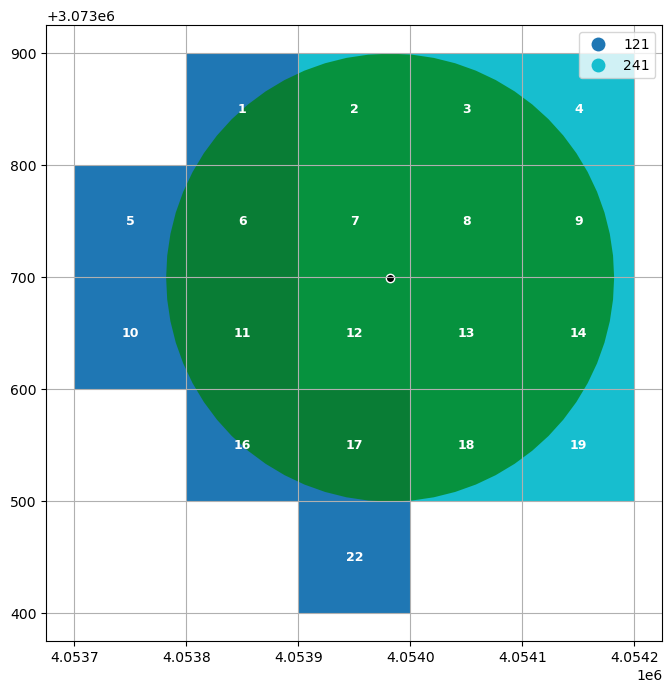

In [19]:
fig = plotRecord(jdf, buffer)

In [ ]:
buffer = gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(200)

In [177]:
distance = 200

In [178]:
buffers = [gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

In [179]:
j0 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[0])
j1 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[1].difference(buffers[0]).geometry)
j2 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[2].difference(buffers[1]).geometry)

Loading raster.
Loaded raster successfully. 
Clipped raster.
Generating individual pixels.
Joining with CLC
Loading raster.
Loaded raster successfully. 
Clipped raster.
Generating individual pixels.
Joining with CLC
Loading raster.
Loaded raster successfully. 
Clipped raster.
Generating individual pixels.
Joining with CLC


In [247]:
def getWeightedClass(dataframes):
    df0 = dataframes[0]
    df1 = dataframes[1]
    df2 = dataframes[2]

    # drop pixels that occur in multiple buffers
    true_df1 = df1.loc[pd.concat([df0, df1]).normalize().drop_duplicates(keep=False).index]
    true_df2 = df2.loc[pd.concat([df0, df1, df2]).normalize().drop_duplicates(keep=False).index]

    # group all dataframes by their classes
    gdf0= df0[["value", "geometry"]].groupby("value").count()
    gdf1= true_df1[["value", "geometry"]].groupby("value").count()
    gdf2= true_df2[["value", "geometry"]].groupby("value").count()

    # Weigh classes and find class with highest weight
    weighted_frame = (5 * gdf0).add((3 * gdf1), fill_value=0).add((1 * gdf2), fill_value=0)
    print("Weighted classes:", weighted_frame)
    weighted_class = weighted_frame[weighted_frame.geometry == max(weighted_frame.geometry)].index.item()

    return weighted_class

    

In [248]:
getWeightedClass([j0, j1, j2])

Weighted classes:        geometry
value          
2          18.0
18         37.0


18

In [194]:
def plotRecordMultiBuffer(geodataframe, buffers):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    geodataframe.plot(ax=ax, column="CODE_18", legend=True)

    colors = ["red", "orange", "green"]
    for idx, x in enumerate(list(reversed(buffers))):
        x.plot(ax=ax, facecolor=None, hatch='XX', edgecolor=colors[idx], alpha=0.7)
    gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").plot(ax=ax, color='black', edgecolor='white')
    plt.grid()
    for idx, row in geodataframe.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        
        ax.annotate(
            text=str(idx),
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    return fig

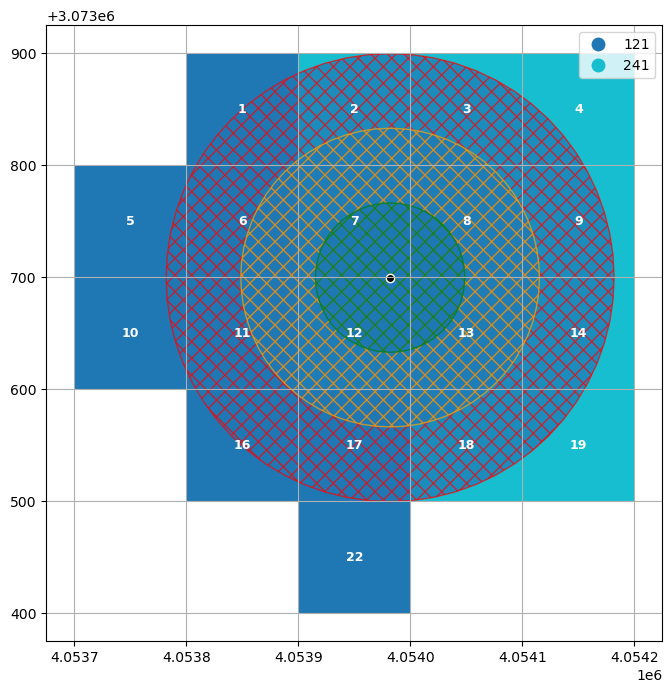

In [239]:
fig = plotRecordMultiBuffer(jdf, buffers)

In [142]:
def getCorineLocationsSingleObj(dir, buffer, distance=200):
    dir_files = os.listdir(dir)

    raster_file = os.path.join(dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    print("Loading raster.")
    with rasterio.open(raster_file) as tif:
        print("Loaded raster successfully. ")
        raster_crs = tif.crs

        # Reproject buffer
        if buffer.crs != raster_crs:
            print("Reprojecting buffer due to differing SRS.")
            buffer = buffer.to_crs(raster_crs)

        # Mask raster to buffer
        image_data, transformed_data = mask(
            dataset=tif,
            shapes=buffer.geometry.tolist(),
            crop=True,
            all_touched=True 
        )

        print("Clipped raster.")

        print("Generating individual pixels.")

        # Get shape
        rows, cols = image_data.shape[1:]

        # Flatten image to a single band
        pixel_values = image_data[0].flatten()

        # Create arrays of all row and column indices
        col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))
        flattened_col_indices = col_indices.flatten()
        flattened_row_indices = row_indices.flatten()

        # # Get raster resolution to compute pixel size
        x_res = abs(transformed_data.a)
        y_res = abs(transformed_data.e)

        # Calculate NW corner of the pixels
        x_ul, y_ul = transformed_data * (flattened_col_indices, flattened_row_indices)

        # North-East (NE) corner
        x_ne = x_ul + x_res
        y_ne = y_ul

        # South-East (SE) corner
        x_se = x_ul + x_res
        y_se = y_ul - y_res # Note: Assuming a north-up, y-decreasing transform

        # South-West (SW) corner
        x_sw = x_ul
        y_sw = y_ul - y_res

        # Define pixel corners in counter-clockwise order:

        geometries = [
            Polygon([
                (x_ul[i], y_ul[i]),  # NW
                (x_ne[i], y_ne[i]),  # NE
                (x_se[i], y_se[i]),  # SE
                (x_sw[i], y_sw[i]),  # SW
                (x_ul[i], y_ul[i])   # NW (Close the ring)
            ])
            for i in range(len(x_ul))
        ]

        # Create geodataframe
        gdf = gpd.GeoDataFrame(
            pd.DataFrame({
                'value': pixel_values,
            }),
            geometry=geometries,
            crs=raster_crs
        )

        # Join geodataframe with CLC
        print("Joining with CLC")
        jdf = gdf.join(dbf_df, on = "value")

        # Get only intersecting pixels
        intersection_result = jdf.intersects(buffer.unary_union)
        
    return jdf[intersection_result]
    

In [143]:
dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
points = getSoundLocations(dir)
sound_point = points.iloc[100]
distance = 200
buffers = [gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

j0 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[0])
j1 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[1].difference(buffers[0]).geometry)
j2 = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffers[2].difference(buffers[1]).geometry)

getWeightedClass([j0, j1, j2])

NameError: name 'getCorineLocationsSingle' is not defined

In [5]:
dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
points = getSoundLocations(dir)

In [151]:
distance = 200
corine_dir = "F:\\Persönliches\\Git\\BioOTon"
recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
dir_files = os.listdir(corine_dir)

raster_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
dbf_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

# Get DBF File
dbf_data = DBF(dbf_file)
dbf_df = pd.DataFrame(iter(dbf_data))

print("Loading raster.")

with rasterio.open(raster_file) as tif:
    print("Loaded raster successfully. ")
    raster_crs = tif.crs

    points = getSoundLocations(recording_dir)

    points["label"] = np.nan
    
    for idx, content in points[:1].iterrows():

        geo_dfs = []

        buffers = [gpd.GeoSeries(content.geometry, crs="EPSG:3035").buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

        for i, buffer in enumerate(buffers):
            if i > 0:
                buffer = buffers[i].difference(buffers[i-1]).geometry

            # buffer.plot()

            # Reproject buffer
            if buffer.crs != raster_crs:
                print(f"Reprojecting buffer{i} due to differing SRS.")
                buffer = buffer.to_crs(raster_crs)

            # Mask raster to buffer
            image_data, transformed_data = mask(
                dataset=tif,
                shapes=buffer.geometry.tolist(),
                crop=True,
                all_touched=True 
            )

            print(f"Clipped raster for buffer {i}.")

            print("Generating individual pixels.")

            # Get shape
            rows, cols = image_data.shape[1:]

            # Flatten image to a single band
            pixel_values = image_data[0].flatten()

            # Create arrays of all row and column indices
            col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))
            flattened_col_indices = col_indices.flatten()
            flattened_row_indices = row_indices.flatten()

            # # Get raster resolution to compute pixel size
            x_res = abs(transformed_data.a)
            y_res = abs(transformed_data.e)

            # Calculate NW corner of the pixels
            x_ul, y_ul = transformed_data * (flattened_col_indices, flattened_row_indices)

            # North-East (NE) corner
            x_ne = x_ul + x_res
            y_ne = y_ul

            # South-East (SE) corner
            x_se = x_ul + x_res
            y_se = y_ul - y_res # Note: Assuming a north-up, y-decreasing transform

            # South-West (SW) corner
            x_sw = x_ul
            y_sw = y_ul - y_res

            # Define pixel corners in counter-clockwise order:

            geometries = [
                Polygon([
                    (x_ul[i], y_ul[i]),  # NW
                    (x_ne[i], y_ne[i]),  # NE
                    (x_se[i], y_se[i]),  # SE
                    (x_sw[i], y_sw[i]),  # SW
                    (x_ul[i], y_ul[i])   # NW (Close the ring)
                ])
                for i in range(len(x_ul))
            ]

            # Create geodataframe
            geo_df = gpd.GeoDataFrame(
                pd.DataFrame({
                    'value': pixel_values,
                }),
                geometry=geometries,
                crs=raster_crs
            )

            geo_dfs.append(geo_df)
        
        # print(geo_dfs)


        # drop pixels that occur in multiple buffers
        print("Dropping duplicate pixels.")
        geo_dfs[1] = geo_dfs[1].loc[pd.concat([geo_dfs[0], geo_dfs[1]]).normalize().drop_duplicates(keep=False).index]
        geo_dfs[2] = geo_dfs[2].loc[pd.concat([geo_dfs[0], geo_dfs[1], geo_dfs[2]]).normalize().drop_duplicates(keep=False).index]


        filtered_dfs = []

        for pos, frame in enumerate(geo_dfs):
            joined_df = frame.join(dbf_df, on = "value")

            # Get only intersecting pixels
            intersection_result = joined_df.intersects(buffer.union_all())
        
            filtered_dfs.append(joined_df[intersection_result])
        
        grouped_dfs = []

        for pos, frame in enumerate(filtered_dfs):
            grouped_frame = filtered_dfs[pos][["value", "geometry"]].groupby("value").count()
            print(grouped_frame)
            if grouped_frame.empty:
                print(f"gdf empty")
                grouped_frame = pd.DataFrame({'value':[-128], 'geometry': [0]})
                grouped_frame.set_index('value', inplace=True)
            grouped_dfs.append(grouped_frame)

        # print(grouped_dfs)
        # Weigh classes and find class with highest weight
        weighted_frame = (5 * grouped_dfs[0]).add((3 * grouped_dfs[1]), fill_value=0).add((1 * grouped_dfs[2]), fill_value=0)
        print("Weighted classes:", weighted_frame)

        # Ignore NAN
        weighted_frame.loc[weighted_frame.index==-128, 'geometry'] = 0
        print(weighted_frame)

        # How to handle identical values??, e.g. recording 402
        weighted_class = weighted_frame.idxmax().item()


        print("Assigned: ",weighted_class)

        points.loc[points.index==idx, 'label'] = weighted_class

Loading raster.
Loaded raster successfully. 
Clipped raster for buffer 0.
Generating individual pixels.
Clipped raster for buffer 1.
Generating individual pixels.
Clipped raster for buffer 2.
Generating individual pixels.
Dropping duplicate pixels.
       geometry
value          
2             4
       geometry
value          
2             6
       geometry
value          
1             2
2             8
Weighted classes:        geometry
value          
1           2.0
2          46.0
       geometry
value          
1           2.0
2          46.0
Assigned:  2


In [152]:
points.head()

,id,geometry,label
0,9815166,POINT (4046607.241 3080261.129),2.0
1,9814704,POINT (4055573.539 3079768.958),NaN
2,9814726,POINT (4055656.811 3079796.646),NaN
3,9814099,POINT (4045874.317 3088960.001),NaN
4,9814098,POINT (4045874.021 3088956.97),NaN


In [113]:
points.to_parquet("points.parquet")

In [111]:
points.head(76600)

,id,geometry,label
0,9815166,POINT (4046607.241 3080261.129),2.0
1,9814704,POINT (4055573.539 3079768.958),2.0
2,9814726,POINT (4055656.811 3079796.646),2.0
3,9814099,POINT (4045874.317 3088960.001),18.0
4,9814098,POINT (4045874.021 3088956.970),18.0
...,...,...,...
76595,22751455,POINT (4261307.041 2800916.451),18.0
76596,22751538,POINT (4261307.429 2800916.669),18.0
76597,22779589,POINT (4230517.187 2799994.892),12.0
76598,22779600,POINT (4261304.595 2800911.132),18.0


In [147]:
def processRecordings(corine_dir, recording_dir, distance = 200):
    dir_files = os.listdir(corine_dir)

    raster_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    points = getSoundLocations(recording_dir)
    points["label"] = np.nan

    print("Loading raster.")

    with rasterio.open(raster_file) as tif:
        print("Loaded raster successfully. ")
        raster_crs = tif.crs

        # Reproject points
        if points.crs != raster_crs:
            print(f"Reprojecting points due to differing SRS.")
            points = points.to_crs(raster_crs)

        # Get raster resolution to compute pixel size
        x_res, y_res = tif.res

        for idx, content in points[:100].iterrows():

            geo_dfs = []

            buffers = [gpd.GeoSeries(content.geometry, crs="EPSG:3035").buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

            for i, buffer in enumerate(buffers):
                if i > 0:
                    buffer = buffers[i].difference(buffers[i-1]).geometry

                # buffer.plot()

                # Mask raster to buffer
                image_data, transformed_data = mask(
                    dataset=tif,
                    shapes=buffer.geometry.tolist(),
                    crop=True,
                    all_touched=True 
                )

                print(f"Clipped raster for buffer {i}.")

                print("Generating individual pixels.")

                # Get shape
                rows, cols = image_data.shape[1:]

                # Flatten image to a single band
                pixel_values = image_data[0].flatten()

                # Create arrays of all row and column indices
                col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))
                flattened_col_indices = col_indices.flatten()
                flattened_row_indices = row_indices.flatten()

                # Calculate NW corner of the pixels
                x_ul, y_ul = transformed_data * (flattened_col_indices, flattened_row_indices)

                # North-East (NE) corner
                x_ne = x_ul + x_res
                y_ne = y_ul

                # South-East (SE) corner
                x_se = x_ul + x_res
                y_se = y_ul - y_res # Note: Assuming a north-up, y-decreasing transform

                # South-West (SW) corner
                x_sw = x_ul
                y_sw = y_ul - y_res

                # Define pixel corners in counter-clockwise order:

                geometries = [
                    Polygon([
                        (x_ul[i], y_ul[i]),  # NW
                        (x_ne[i], y_ne[i]),  # NE
                        (x_se[i], y_se[i]),  # SE
                        (x_sw[i], y_sw[i]),  # SW
                        (x_ul[i], y_ul[i])   # NW (Close the ring)
                    ])
                    for i in range(len(x_ul))
                ]

                # Create geodataframe
                geo_df = gpd.GeoDataFrame(
                    pd.DataFrame({
                        'value': pixel_values,
                    }),
                    geometry=geometries,
                    crs=raster_crs
                )

                geo_dfs.append(geo_df)
            
            # print(geo_dfs)


            # drop pixels that occur in multiple buffers
            print("Dropping duplicate pixels.")
            geo_dfs[1] = geo_dfs[1].loc[pd.concat([geo_dfs[0], geo_dfs[1]]).normalize().drop_duplicates(keep=False).index]
            geo_dfs[2] = geo_dfs[2].loc[pd.concat([geo_dfs[0], geo_dfs[1], geo_dfs[2]]).normalize().drop_duplicates(keep=False).index]


            filtered_dfs = []

            for pos, frame in enumerate(geo_dfs):
                joined_df = frame.join(dbf_df, on = "value")

                # Get only intersecting pixels
                intersection_result = joined_df.intersects(buffer.union_all())
            
                filtered_dfs.append(joined_df[intersection_result])
            
            grouped_dfs = []

            for pos, frame in enumerate(filtered_dfs):
                grouped_frame = filtered_dfs[pos][["value", "geometry"]].groupby("value").count()
                print(grouped_frame)
                if grouped_frame.empty:
                    print(f"gdf empty")
                    grouped_frame = pd.DataFrame({'value':[-128], 'geometry': [0]})
                    grouped_frame.set_index('value', inplace=True)
                grouped_dfs.append(grouped_frame)

            # print(grouped_dfs)
            # Weigh classes and find class with highest weight
            weighted_frame = (5 * grouped_dfs[0]).add((3 * grouped_dfs[1]), fill_value=0).add((1 * grouped_dfs[2]), fill_value=0)
            print("Weighted classes:", weighted_frame)

            # Ignore NAN
            weighted_frame.loc[weighted_frame.index==-128, 'geometry'] = 0
            print(weighted_frame)

            # How to handle identical values??, e.g. recording 402
            weighted_class = weighted_frame.idxmax().item()


            print(f"Assigned class {weighted_class} to point {idx}")

            points.loc[points.index==idx, 'label'] = weighted_class

In [291]:
processRecordings(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data")

Loading raster.
Loaded raster successfully. 
Clipped raster for buffer 0.
Generating individual pixels.
Clipped raster for buffer 1.
Generating individual pixels.
Clipped raster for buffer 2.
Generating individual pixels.
Dropping duplicate pixels.
       geometry
value          
18            2
       geometry
value          
-128          2
 2            5
 18           5
       geometry
value          
2             3
Weighted classes:        geometry
value          
-128        6.0
 2         18.0
 18        25.0
       geometry
value          
-128        0.0
 2         18.0
 18        25.0
Assigned class 18 to point 100


In [148]:
pframe = pd.read_parquet("points.parquet")

(array([  187.,     0.,     0.,     0.,     0.,     0.,     0., 55192.,
        20766.,   491.]),
 array([-128. , -110.9,  -93.8,  -76.7,  -59.6,  -42.5,  -25.4,   -8.3,
           8.8,   25.9,   43. ]),
 <BarContainer object of 10 artists>)

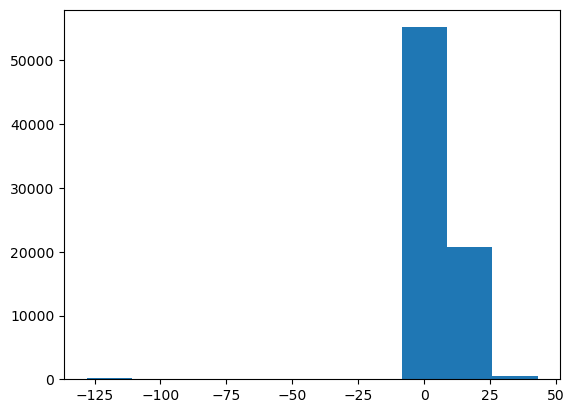

In [150]:
plt.hist(pframe["label"])

In [59]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.transform import rowcol, xy
from dbfread import DBF # Assuming you use dbfread or simpledbf
from itertools import compress

def processRecordingsNP(corine_dir, recording_dir, distance=200):
    dir_files = os.listdir(corine_dir)

    # File finding logic preserved
    raster_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Load DBF once (lookup table)
    print("Loading DBF...")
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))
    # Ensure we can join on the value column (assuming standard CLC 'VAL' or similar, usually column 0 or 'Value')
    # We will filter valid classes at the end. 
    valid_classes = set(dbf_df.iloc[:, 0].unique()) 

    points = getSoundLocations(recording_dir)
    points["label"] = np.nan

    print("Opening Raster...")
    with rasterio.open(raster_file) as src:
        raster_crs = src.crs
        
        # Pre-calculate resolution for sanity checks if needed
        res_x, res_y = src.res

        print(f"Processing {len(points)} points...")

        for idx, content in points[:1000].iterrows():
            
            # 1. Coordinate Setup
            # Get geometry and ensure it's in the Raster CRS
            pt_geom = content.geometry
            if points.crs != raster_crs:
                # Create a temporary geoseries to reproject just this point
                pt_gs = gpd.GeoSeries([pt_geom], crs=points.crs)
                pt_geom = pt_gs.to_crs(raster_crs)[0]

            px, py = pt_geom.x, pt_geom.y

            # 2. Define the Window of Interest
            # We only read the square bounding box around the max distance
            # Pad slightly to ensure we catch the edges
            window = from_bounds(
                px - distance, py - distance, 
                px + distance, py + distance, 
                src.transform
            )
            
            # Read data in that window
            # masked=True returns a masked array where nodata is handled
            data = src.read(1, window=window, masked=True)
            
            # If the window is empty/off-map, skip
            if data is None or data.size == 0:
                continue

            # 3. Flatten the Data
            # We flatten the 2D grid into a 1D array of pixels. 
            # This makes matching them with the coordinate lists much easier.
            data_flat = data.flatten()
            
            # If the window is totally empty or masked, skip
            if data_flat.count() == 0:
                continue

            # 4. Generate Pixel Coordinates (1D)
            height, width = data.shape
            
            # Create 2D indices, then flatten them immediately
            row_indices, col_indices = np.indices((height, width))
            row_flat = row_indices.flatten()
            col_flat = col_indices.flatten()

            # Calculate the spatial center of every pixel (returns lists)
            window_transform = src.window_transform(window)
            pixel_xs, pixel_ys = rasterio.transform.xy(window_transform, row_flat, col_flat, offset='center')
            
            # Convert to numpy arrays for math
            pixel_xs = np.array(pixel_xs)
            pixel_ys = np.array(pixel_ys)

            # 5. Calculate Distances (Vectorized)
            # Now both pixel_xs and px are compatible
            dists = np.sqrt((pixel_xs - px)**2 + (pixel_ys - py)**2)

            # 6. Classify Pixels into Zones
            # Define limits
            limit_1 = distance / 3
            limit_2 = (distance / 3) * 2
            limit_3 = distance

            # Create boolean masks. 
            # Note: ~data_flat.mask identifies valid pixels (not NoData)
            valid_pixels = ~data_flat.mask
            
            # Now everything is 1D, so these operations will work
            mask_zone_0 = valid_pixels & (dists <= limit_1)
            mask_zone_1 = valid_pixels & (dists > limit_1) & (dists <= limit_2)
            mask_zone_2 = valid_pixels & (dists > limit_2) & (dists <= limit_3)

            # 7. Aggregate Counts
            # Helper function (same as before, but works on flat arrays)
            def get_counts(flat_raster, mask):
                values = flat_raster[mask]
                if values.size == 0:
                    return pd.Series(dtype=float)
                unique, counts = np.unique(values, return_counts=True)
                return pd.Series(counts, index=unique)

            counts_0 = get_counts(data_flat, mask_zone_0)
            counts_1 = get_counts(data_flat, mask_zone_1)
            counts_2 = get_counts(data_flat, mask_zone_2)

            # 7. Apply Weights
            # Align them into a single DataFrame filling missing classes with 0
            df_weights = pd.DataFrame({
                'zone_0': counts_0,
                'zone_1': counts_1,
                'zone_2': counts_2
            }).fillna(0)

            # Apply your logic: (5 * inner) + (3 * middle) + (1 * outer)
            df_weights['total_score'] = (df_weights['zone_0'] * 5) + \
                                        (df_weights['zone_1'] * 3) + \
                                        (df_weights['zone_2'] * 1)

            if df_weights.empty:
                print(f"No data for point {idx}")
                points.loc[idx, 'label'] = -128 # or suitable default
                continue

            # Filter logic: Ensure the value exists in the DBF (optional based on your code)
            # valid_classes logic can be applied here if needed
            
            # Find the winner
            weighted_class = df_weights['total_score'].idxmax()
            
            print(f"Point {idx}: Assigned Class {weighted_class}")
            points.loc[idx, 'label'] = weighted_class

    return points

In [60]:
processRecordingsNP(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data")

Loading DBF...
Opening Raster...
Processing 76636 points...
Point 0: Assigned Class 2
Point 1: Assigned Class 2
Point 2: Assigned Class 2
Point 3: Assigned Class 18
Point 4: Assigned Class 18
Point 5: Assigned Class 2
Point 6: Assigned Class 2
Point 7: Assigned Class 2
Point 8: Assigned Class 2
Point 9: Assigned Class 2
Point 10: Assigned Class 2
Point 11: Assigned Class 2
Point 12: Assigned Class 2
Point 13: Assigned Class 2
Point 14: Assigned Class 2
Point 15: Assigned Class 2
Point 16: Assigned Class 2
Point 17: Assigned Class 2
Point 18: Assigned Class 2
Point 19: Assigned Class 2
Point 20: Assigned Class 2
Point 21: Assigned Class 2
Point 22: Assigned Class 2
Point 23: Assigned Class 2
Point 24: Assigned Class 2
Point 25: Assigned Class 2
Point 26: Assigned Class 2
Point 27: Assigned Class 2
Point 28: Assigned Class 2
Point 29: Assigned Class 2
Point 30: Assigned Class 2
Point 31: Assigned Class 2
Point 32: Assigned Class 2
Point 33: Assigned Class 2
Point 34: Assigned Class 2
Poi

,id,geometry,label
0,9815166,POINT (4046607.241 3080261.129),2.0
1,9814704,POINT (4055573.539 3079768.958),2.0
2,9814726,POINT (4055656.811 3079796.646),2.0
3,9814099,POINT (4045874.317 3088960.001),18.0
4,9814098,POINT (4045874.021 3088956.970),18.0
...,...,...,...
76631,23023147,POINT (4509261.004 3071891.374),NaN
76632,27438973,POINT (4508173.319 3072239.981),NaN
76633,27905708,POINT (4496489.119 3068628.571),NaN
76634,27905712,POINT (4496489.119 3068628.571),NaN


In [153]:
distance = 200
corine_dir = "F:\\Persönliches\\Git\\BioOTon"
recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
dir_files = os.listdir(corine_dir)
x_range=np.arange(1)#"all"

raster_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
dbf_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

# Get DBF File
dbf_data = DBF(dbf_file)
dbf_df = pd.DataFrame(iter(dbf_data))

points = getSoundLocations(recording_dir)
points["label"] = np.nan

print("Loading raster.")

if type(x_range) == str:
    x_range = np.arange(len(points))

Loading raster.


In [205]:
with rasterio.open(raster_file) as tif:
    print("Loaded raster successfully. ")
    raster_crs = tif.crs

    # Reproject points
    if points.crs != raster_crs:
        print(f"Reprojecting points due to differing SRS.")
        points = points.to_crs(raster_crs)

    # Get raster resolution to compute pixel size
    x_res, y_res = tif.res

    for idx, content in points.iloc[x_range].iterrows():

        geo_dfs = []

        buffers = [gpd.GeoSeries(content.geometry, crs=raster_crs).buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

        print(buffers)

        image_data, transformed_data = mask(
                dataset=tif,
                shapes=buffers[2].to_crs(raster_crs).geometry.tolist(),
                crop=True,
                all_touched=True 
            )
        
        print(f"Clipped raster for buffer.")

        print("Generating individual pixels.")

        # Get shape
        rows, cols = image_data.shape[1:]
        print(rows, cols)
        # Flatten image to a single band
        pixel_values = image_data[0].flatten()

        # Create arrays of all row and column indices
        col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

        xs, ys = rasterio.transform.xy(transformed_data, row_indices.flatten(), col_indices.flatten())

        print(xs, ys)

        geometries = gpd.points_from_xy(xs, ys)#.buffer(x_res/ 2, cap_style='square')[0]]

        # Create geodataframe
        geo_df = gpd.GeoDataFrame(
            pd.DataFrame({
                'value': pixel_values,
            }),
            geometry=geometries,
            crs=raster_crs
        )

        # If squares are not explicitly needed, comment this out
        geo_df['geometry'] = geo_df.buffer(x_res / 2, cap_style="square")

        print(geo_df)

        for i, buffer in enumerate(buffers):
            if i > 0:
                buffer = buffers[i].difference(buffers[i-1])

            results = geo_df.intersects(buffer.geometry.iloc[0], align=True)#.clip(buffer)

            print(results)

            print(f"Clipped raster for buffer {i}.")

            print("Generating individual pixels.")

            geo_dfs.append(geo_df[results])

        # drop pixels that occur in multiple buffers
        first_ring = pd.concat([geo_dfs[0], geo_dfs[1]])
        second_ring = pd.concat(geo_dfs)

        geo_dfs[1] = first_ring.loc[first_ring.normalize().drop_duplicates(keep=False).index]
        geo_dfs[2] = second_ring.loc[second_ring.normalize().drop_duplicates(keep=False).index]

        filtered_dfs = []

        for pos, frame in enumerate(geo_dfs):
            # Get only intersecting pixels
            # Need to combine the three buffers into one large one
            intersection_result = frame.intersects(pd.concat(buffers).union_all())




            selection = frame[intersection_result]
            joined_df = selection.join(dbf_df, on = "value")
        
            filtered_dfs.append(joined_df)
        
        grouped_dfs = []

        for pos, frame in enumerate(filtered_dfs):
            grouped_frame = filtered_dfs[pos][["CODE_18", "geometry"]].groupby("CODE_18").count()
            print(grouped_frame)
            if grouped_frame.empty:
                print(f"gdf empty")
                grouped_frame = pd.DataFrame({'CODE_18':[-128], 'geometry': [0]})
                grouped_frame.set_index('CODE_18', inplace=True)
                
            grouped_dfs.append(grouped_frame)

        # print(grouped_dfs)
        # Weigh classes and find class with highest weight
        weighted_frame = (5 * grouped_dfs[0]).add((3 * grouped_dfs[1]), fill_value=0).add((1 * grouped_dfs[2]), fill_value=0)
        print("Weighted classes:", weighted_frame)

        # Ignore NAN
        weighted_frame.loc[weighted_frame.index==-128, 'geometry'] = 0
        print(weighted_frame)

        # How to handle identical values??, e.g. recording 402
        weighted_class = weighted_frame.idxmax().item()


        print(f"Assigned class {weighted_class} to point {idx}")

        points.loc[points.index==idx, 'label'] = weighted_class

Loaded raster successfully. 
[0    POLYGON ((4046673.908 3080261.129, 4046673.587...
dtype: geometry, 0    POLYGON ((4046740.574 3080261.129, 4046739.932...
dtype: geometry, 0    POLYGON ((4046807.241 3080261.129, 4046806.278...
dtype: geometry]
Clipped raster for buffer.
Generating individual pixels.
5 5
[4046450. 4046550. 4046650. 4046750. 4046850. 4046450. 4046550. 4046650.
 4046750. 4046850. 4046450. 4046550. 4046650. 4046750. 4046850. 4046450.
 4046550. 4046650. 4046750. 4046850. 4046450. 4046550. 4046650. 4046750.
 4046850.] [3080450. 3080450. 3080450. 3080450. 3080450. 3080350. 3080350. 3080350.
 3080350. 3080350. 3080250. 3080250. 3080250. 3080250. 3080250. 3080150.
 3080150. 3080150. 3080150. 3080150. 3080050. 3080050. 3080050. 3080050.
 3080050.]
    value                                           geometry
0       2  POLYGON ((4046500 3080500, 4046500 3080400, 40...
1       2  POLYGON ((4046600 3080500, 4046600 3080400, 40...
2       2  POLYGON ((4046700 3080500, 4046700 3080

In [206]:
grouped_dfs

[         geometry
 CODE_18          
 121             6,
          geometry
 CODE_18          
 121             6,
          geometry
 CODE_18          
 112             2
 121             8]

C:\Users\mfher\AppData\Local\Temp\ipykernel_21976\1938558549.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])


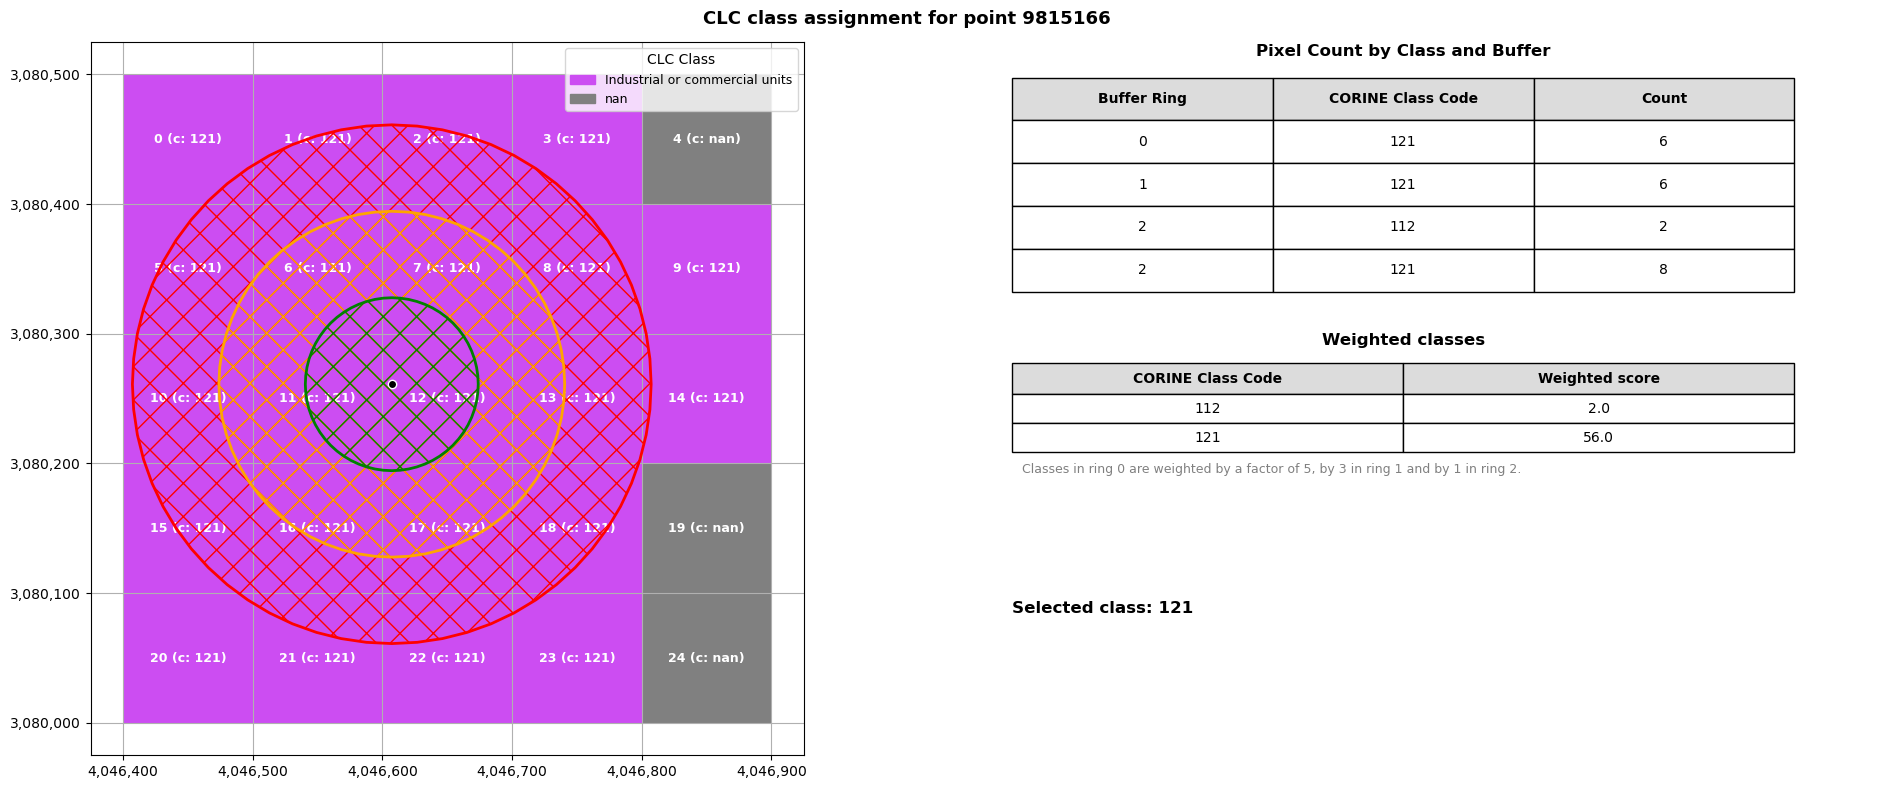

In [208]:
point = 0

geodataframe = joined_df
fig, ax= plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle(f"CLC class assignment for point {points.iloc[point].id}", fontsize=13,fontweight='bold')

x_res = 100

val_frame = geo_df.join(geodataframe, on = "value", how="left", rsuffix='_r')

combined_df = pd.concat(map(pd.DataFrame.reset_index, grouped_dfs), ignore_index=False, keys=[0, 1, 2], names=['df', "idx"])
cdf = combined_df.reset_index().rename(columns={"df":"Buffer Ring", "CODE_18":"CORINE Class Code", "geometry":"Count"}).drop(columns="idx")

color_dict = {
    code: to_hex((R, G, B)) # Matplotlib expects normalized (0.0 to 1.0) RGB first
    for code, R, G, B in zip(dbf_df.CODE_18.values, dbf_df.Red.values, dbf_df.Green.values, dbf_df.Blue.values)
}

codes = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['CODE_18'].tolist()
labels = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['LABEL3'].tolist()

legend_handles = [
    mpatches.Patch(
        color=color_dict.get(code, 'gray'), 
        label=label
    ) 
    for code, label in zip(codes, labels)
]

# geodataframe['geometry'] = geodataframe.buffer(x_res / 2, cap_style="square")
val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])

ax[0].legend(
    handles=legend_handles, 
    title="CLC Class", 
    loc='upper right', 
    frameon=True,
    fontsize=9
)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

ax[0].ticklabel_format(style='plain', useOffset=False, axis='both')

formatter = ticker.StrMethodFormatter('{x:,.0f}')

ax[0].xaxis.set_major_formatter(formatter)
ax[0].yaxis.set_major_formatter(formatter)

colors = ["red", "orange", "green"]
for idx, x in enumerate(list(reversed(buffers))):
    x.plot(
        ax=ax[0], 
        facecolor='none',
        hatch='X', 
        edgecolor=colors[idx], 
        alpha=1.0,
        linewidth=2,
        zorder=5
    )

ax[0].scatter(content.geometry.x, content.geometry.y,  color='black', edgecolor='white')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(100))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(100))

ax[0].grid()

val_frame = geo_df.join(geodataframe, on = "value", how="left", rsuffix='_r')
for idx, row in val_frame.iterrows():
    # Get square center
    centroid_x = row.geometry.centroid.x
    centroid_y = row.geometry.centroid.y
    ax[0].annotate(
        text=f"{str(idx)} (c: {(row.CODE_18)})",
        xy=(centroid_x, centroid_y),
        ha='center',
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold'
    )

combined_data = [cdf.columns.values.tolist()] + cdf.values.tolist()
combined_headers = cdf.columns.tolist()

# Define cell colors (optional, for aesthetics)
cell_colors = [['#f2f2f2'] * len(combined_headers)] + [['white'] * len(combined_headers)] * len(combined_data)

# Add title as text
ax[1].text(0.5, 0.98, "Pixel Count by Class and Buffer", 
           transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')

# Draw the table
table1 = ax[1].table(
    cellText=cdf.values,
    colLabels=combined_headers,
    colLoc='center',
    cellLoc='center',
    loc='top',
    bbox=[0.1, 0.65, 0.8, 0.3]
)
table1.auto_set_font_size(False)
table1.set_fontsize(10)
# Highlight header
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')

w_frame = weighted_frame.reset_index().rename(columns={"CODE_18":"CORINE Class Code", "geometry":"Weighted score"})
weighted_data = [w_frame.columns.values.tolist()] +w_frame.values.tolist()
weighted_headers = w_frame.columns.tolist()


# Add title as text
ax[1].text(0.5, 0.575, "Weighted classes", 
           transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')
# Draw the table
table2 = ax[1].table(
    cellText=w_frame.values,
    colLabels=weighted_headers,
    colLoc='center',
    cellLoc='center',
    loc='top', 
    bbox=[0.1, 0.425, 0.8, 0.125] # Adjust position
)
table2.auto_set_font_size(False)
table2.set_fontsize(10)
for (row, col), cell in table2.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')
        cell.set_height(0.029)

# Hide axes
ax[1].axis('off')

weight_text = "Classes in ring 0 are weighted by a factor of 5, by 3 in ring 1 and by 1 in ring 2."

ax[1].text(0.11, 0.4, weight_text, 
           transform=ax[1].transAxes, ha='left', va='center', fontsize=9, color="grey")

ax[1].text(0.1, 0.2, f"Selected class: {points.iloc[point].label}", fontsize= 12, fontweight = "bold")


plt.tight_layout()
plt.show()

In [46]:
val_frame

,value,geometry,value_r,geometry_r,Value,Count,LABEL3,Red,Green,Blue,CODE_18
0,-128,"POLYGON ((4044600 3081600, 4044600 3081500, 40...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",1.0,"POLYGON ((4044900 3081600, 4044900 3081500, 40...",2.0,17085234.0,Discontinuous urban fabric,1.0,0.0,0.0,112
2,1,"POLYGON ((4044800 3081600, 4044800 3081500, 40...",3.0,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",4.0,414626.0,Road and rail networks and associated land,0.8,0.0,0.0,122
3,1,"POLYGON ((4044900 3081600, 4044900 3081500, 40...",3.0,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",4.0,414626.0,Road and rail networks and associated land,0.8,0.0,0.0,122
4,1,"POLYGON ((4045000 3081600, 4045000 3081500, 40...",3.0,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",4.0,414626.0,Road and rail networks and associated land,0.8,0.0,0.0,122
5,-128,"POLYGON ((4044600 3081500, 4044600 3081400, 40...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,"POLYGON ((4044700 3081500, 4044700 3081400, 40...",1.0,"POLYGON ((4044900 3081600, 4044900 3081500, 40...",2.0,17085234.0,Discontinuous urban fabric,1.0,0.0,0.0,112
7,3,"POLYGON ((4044800 3081500, 4044800 3081400, 40...",1.0,"POLYGON ((4044900 3081600, 4044900 3081500, 40...",2.0,17085234.0,Discontinuous urban fabric,1.0,0.0,0.0,112
8,1,"POLYGON ((4044900 3081500, 4044900 3081400, 40...",3.0,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",4.0,414626.0,Road and rail networks and associated land,0.8,0.0,0.0,122
9,1,"POLYGON ((4045000 3081500, 4045000 3081400, 40...",3.0,"POLYGON ((4044700 3081600, 4044700 3081500, 40...",4.0,414626.0,Road and rail networks and associated land,0.8,0.0,0.0,122
